# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [21]:
# pip install scipy==1.1.0

In [22]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [23]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [24]:
def plot_score(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/ML data /Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/ML data /Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    #print("\n running generator ")
    #print( '\n Source path = ', source_path, '\n batch size =', batch_size )
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    #print("\n img_idx =" , img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        #print("\n num_batches =" , num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            #print("\n Processing batch = ", batch) 
            #print("\n batch: ",batch)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image_resized = resize(image,(120,120))
                    image_resized = image_resized/255 #(image_resized - image_resized.min())/(image_resized.max() - image_resized.min())
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            #print("\n Processing batch left after full batches" ,   )
            
            batch_size = len(folder_list) - (batch_size*num_batches)
            #print("\n batch_size: ", batch_size)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(120,120))  # resize the image 
                    image_resized = image_resized/255 # Normalize the image 

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [28]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/ML data /Project_data/train'
val_path = '/content/drive/MyDrive/ML data /Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers 
import keras

#write your model here

model =  Sequential()

model.add(Conv3D(8,  kernel_size=(3,3,3),  input_shape=(30, 120, 120, 3),  padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16,kernel_size=(3,3,3),  padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [30]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 16)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = '/content/drive/MyDrive/ML data /Project_data/'+'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]



The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Experiment 1 - batch size = 10 , epoch= 20 , learning_rate=0.001

In [34]:
num_epochs = 20 
batch_size = 10

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 6186s 94s/step - loss: 2.8606 - categorical_accuracy: 0.2700 - val_loss: 2.8268 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2712_47_55.891021/model-00001-2.86058-0.26998-2.82676-0.21000.h5
Epoch 2/20
67/67 [==============================] - 87s 1s/step - loss: 1.4701 - categorical_accuracy: 0.3731 - val_loss: 3.4489 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2712_47_55.891021/model-00002-1.47009-0.37313-3.44888-0.22000.h5
Epoch 3/20
67/67 [==============================] - 102s 2s/step - loss: 1.3299 - categorical_accuracy: 0.4527 - val_loss: 4.8587 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2712_47_55.891021/model-00003-1.32993-0.45274-4.85870-0.20000.h5

Epoch 00003: ReduceLROnPla

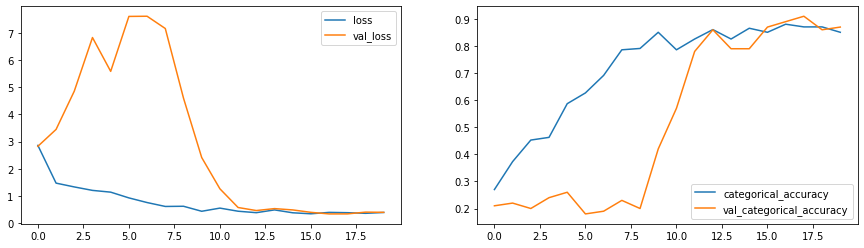

In [35]:
plot_score(history)


### Experiment 2 - batch size = 15 , epoch= 20 ,  , learning_rate=0.001



In [ ]:
num_epochs = 15 
batch_size = 10

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




Epoch 1/20
67/67 [==============================] - 274s 4s/step - loss: 4.9557 - categorical_accuracy: 0.2504 - val_loss: 2.0997 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-4.95566-0.25038-2.09966-0.16000.h5
Epoch 2/20
67/67 [==============================] - 116s 2s/step - loss: 2.1352 - categorical_accuracy: 0.2537 - val_loss: 1.7419 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-2.13520-0.25373-1.74189-0.22000.h5
Epoch 3/20
67/67 [==============================] - 124s 2s/step - loss: 1.8407 - categorical_accuracy: 0.2687 - val_loss: 2.0858 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-1.84071-0.26866-2.08579-0.20000.h5
Epoch 4/20
67/67 [==========

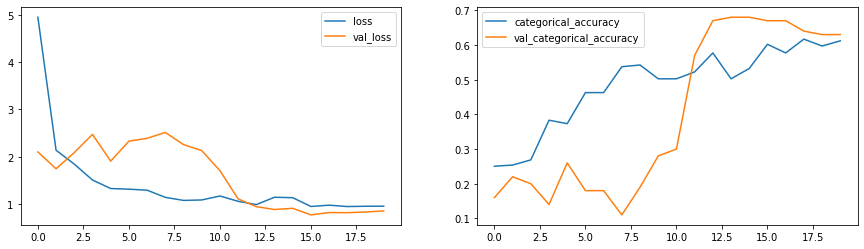

In [ ]:
plot_score(history)


### Experiment 2 - batch size = 100  epoch=20




In [ ]:
batch_size =  25
num_epochs = 20 

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 46s 2s/step - loss: 0.8419 - categorical_accuracy: 0.6420 - val_loss: 0.9658 - val_categorical_accuracy: 0.5750

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-0.84188-0.64198-0.96579-0.57500.h5
Epoch 2/20
27/27 [==============================] - 48s 2s/step - loss: 0.7747 - categorical_accuracy: 0.7160 - val_loss: 0.6946 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-0.77469-0.71605-0.69457-0.75000.h5
Epoch 3/20
27/27 [==============================] - 51s 2s/step - loss: 0.8042 - categorical_accuracy: 0.7037 - val_loss: 0.8369 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-0.80416-0.70370-0.83693-0.65000.h5
Epoch 4/20
27/27 [=============

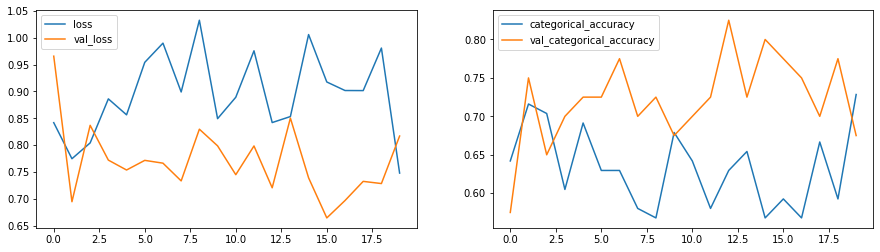

In [ ]:
plot_score(history)

### Experiment 3 - batch size = 50 , epoch =20 












In [ ]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 27s 2s/step - loss: 0.7990 - categorical_accuracy: 0.7143 - val_loss: 0.6578 - val_categorical_accuracy: 0.7500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-0.79898-0.71429-0.65778-0.75000.h5
Epoch 2/20
14/14 [==============================] - 28s 2s/step - loss: 1.0451 - categorical_accuracy: 0.6190 - val_loss: 0.8891 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-1.04512-0.61905-0.88906-0.60000.h5
Epoch 3/20
14/14 [==============================] - 24s 2s/step - loss: 0.9164 - categorical_accuracy: 0.6190 - val_loss: 0.8053 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-0.91640-0.61905-0.80526-0.80000.h5

Epoch 00003: ReduceLROnPlateau

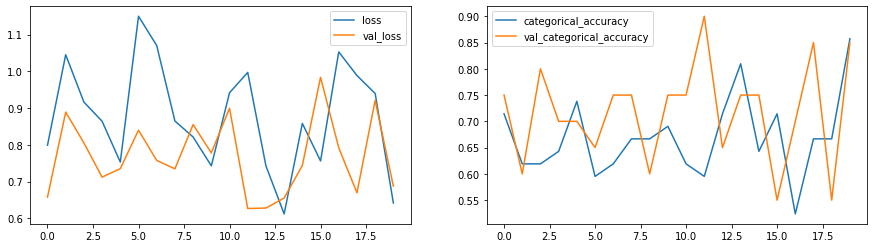

In [ ]:
plot_score(history)

### Experiment 4 - batch size = 50 , epoch =20 , learning_rate=0.0001

In [26]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
14/14 [==============================] - 23s 2s/step - loss: 0.9882 - categorical_accuracy: 0.5238 - val_loss: 1.5786 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-0.98820-0.52381-1.57861-0.25000.h5
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 0.9673 - categorical_accuracy: 0.6905 - val_loss: 1.5585 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-0.96734-0.69048-1.55845-0.35000.h5
Epoch 3/20
14/14 [==============================] - 21s 2s/step - loss: 1.1325 - categorical_accuracy: 0.5952 - val_loss: 1.4266 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-1.13253-0.59524-1.42656-0.40000.h5
Epoch 4/20
14/14 [=============

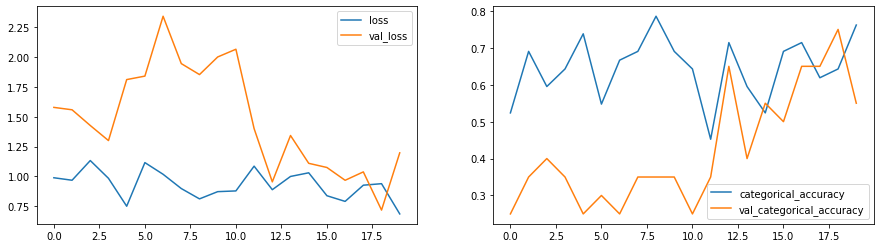

In [27]:
plot_score(history)

### Experiment 5 - batch size = 60 , epoch =20 





In [ ]:
num_epochs = 20
batch_size =  60

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
12/12 [==============================] - 23s 2s/step - loss: 0.8498 - categorical_accuracy: 0.5278 - val_loss: 0.6820 - val_categorical_accuracy: 0.9000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-0.84982-0.52778-0.68197-0.90000.h5
Epoch 2/20
12/12 [==============================] - 22s 2s/step - loss: 0.9947 - categorical_accuracy: 0.5278 - val_loss: 1.0125 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-0.99470-0.52778-1.01249-0.55000.h5
Epoch 3/20
12/12 [==============================] - 23s 2s/step - loss: 0.7354 - categorical_accuracy: 0.7500 - val_loss: 0.6432 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-0.73541-0.75000-0.64322-0.80000.h5
Epoch 4/20
12/12 [=============

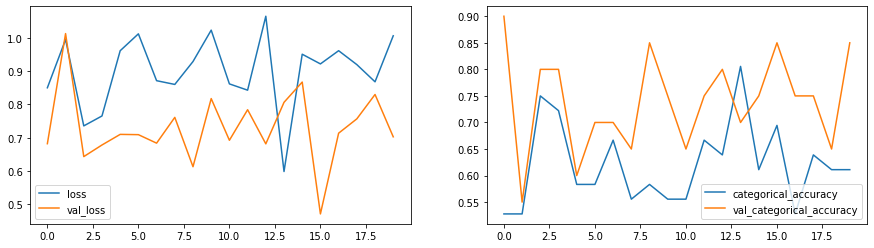

In [ ]:
plot_score(history)

### Changing the Model layers -  removed layer of 8 filters and Added a new layer of 128 filters -  









In [29]:
model_2 =  Sequential()

model_2.add(Conv3D(16,kernel_size=(3,3,3),  input_shape=(30, 120, 120, 3),  padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Adding this layer 
model_2.add(Conv3D(128, kernel_size=(1,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(1000, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(500, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)   

### Experiment 6 with new added layers and batch size = 25 epoch = 20

In [ ]:
num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 49s 2s/step - loss: 21.4409 - categorical_accuracy: 0.1481 - val_loss: 2.9456 - val_categorical_accuracy: 0.1750

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-21.44086-0.14815-2.94561-0.17500.h5
Epoch 2/20
27/27 [==============================] - 47s 2s/step - loss: 14.4159 - categorical_accuracy: 0.2099 - val_loss: 2.3845 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-14.41595-0.20988-2.38448-0.25000.h5
Epoch 3/20
27/27 [==============================] - 47s 2s/step - loss: 5.7098 - categorical_accuracy: 0.2222 - val_loss: 2.2778 - val_categorical_accuracy: 0.1000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-5.70985-0.22222-2.27784-0.10000.h5
Epoch 4/20
27/27 [=========

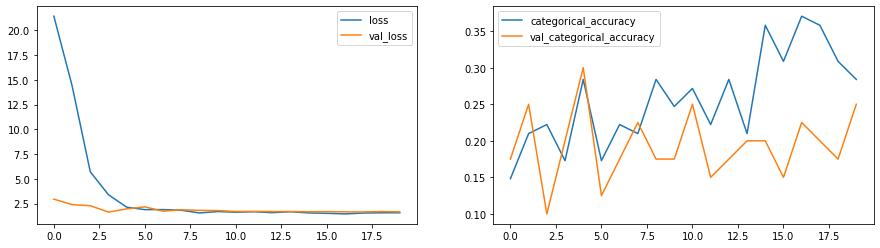

In [ ]:
plot_score(history)

### Experiment 7 with new added layers and batch size = 50 epoch = 20

In [ ]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 26s 2s/step - loss: 1.4606 - categorical_accuracy: 0.3333 - val_loss: 1.6510 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00001-1.46062-0.33333-1.65097-0.15000.h5
Epoch 2/20
14/14 [==============================] - 27s 2s/step - loss: 1.4263 - categorical_accuracy: 0.3095 - val_loss: 1.7105 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00002-1.42630-0.30952-1.71054-0.25000.h5
Epoch 3/20
14/14 [==============================] - 24s 2s/step - loss: 1.5365 - categorical_accuracy: 0.2857 - val_loss: 1.5886 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2416_32_56.502560/model-00003-1.53655-0.28571-1.58858-0.30000.h5
Epoch 4/20
14/14 [=============

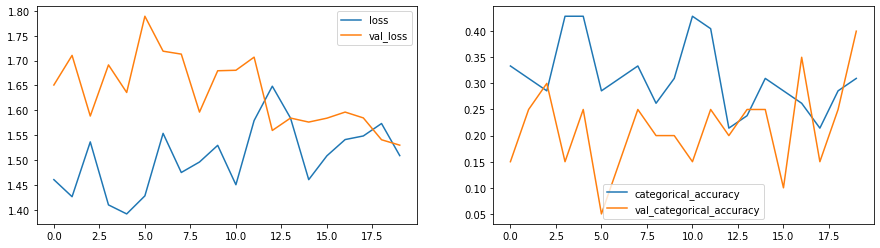

In [ ]:
plot_score(history)

### Experiment 8 with new added layers and batch size = 50 epoch = 20 , learning_rate=0.0001

In [30]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 22s 2s/step - loss: 3.4481 - categorical_accuracy: 0.1429 - val_loss: 1.6054 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-3.44809-0.14286-1.60544-0.25000.h5
Epoch 2/20
14/14 [==============================] - 17s 1s/step - loss: 3.8951 - categorical_accuracy: 0.2381 - val_loss: 1.6153 - val_categorical_accuracy: 0.1000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-3.89513-0.23810-1.61527-0.10000.h5
Epoch 3/20
14/14 [==============================] - 22s 2s/step - loss: 4.1074 - categorical_accuracy: 0.1667 - val_loss: 1.6950 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-4.10737-0.16667-1.69497-0.20000.h5

Epoch 00003: ReduceLROnPlateau

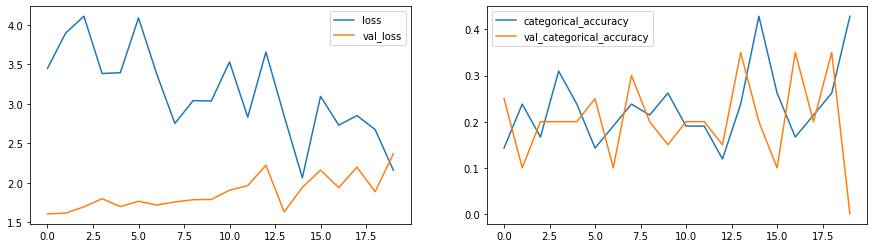

In [31]:
plot_score(history)



### Model with CNN + LSTM 


In [14]:

from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.layers.recurrent import LSTM , GRU
from keras.layers import TimeDistributed


In [15]:
        lstm_cells=128
        dense_neurons=128
        dropout=0.25
        frames_to_sample=30
        image_height=120
        image_width=120
        channels=3
        num_classes=5
        total_frames=30

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(num_classes, activation='softmax'))
        #optimiser = tf.keras.optimizers.Adam()
        #model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 64)   



```
# This is formatted as code
```

### Experiment 9 - with CNN + LSTM  -  epoch =20 , batch size = 25 , learning_rate=0.0001

In [17]:
num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 853s 33s/step - loss: 1.5983 - categorical_accuracy: 0.2815 - val_loss: 1.6012 - val_categorical_accuracy: 0.2250

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-1.59827-0.28148-1.60124-0.22500.h5
Epoch 2/20
27/27 [==============================] - 3440s 132s/step - loss: 1.4812 - categorical_accuracy: 0.3370 - val_loss: 1.6264 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-1.48121-0.33704-1.62639-0.20000.h5
Epoch 3/20
27/27 [==============================] - 2116s 81s/step - loss: 1.3614 - categorical_accuracy: 0.3758 - val_loss: 1.7123 - val_categorical_accuracy: 0.1750

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-1.36139-0.37576-1.71235-0.17500.h5

Epoch 00003: ReduceLR

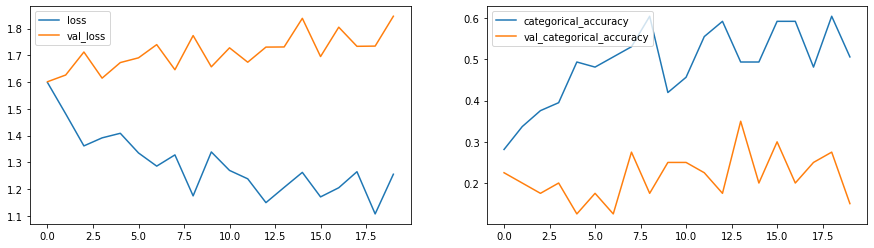

In [18]:
plot_score(history)

### Experiment 10 - with CNN + LSTM  -  epoch =20 , batch size = 50 , learning_rate=0.0001

In [20]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 23s 2s/step - loss: 1.1686 - categorical_accuracy: 0.7143 - val_loss: 1.7844 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-1.16864-0.71429-1.78443-0.15000.h5
Epoch 2/20
14/14 [==============================] - 24s 2s/step - loss: 1.2281 - categorical_accuracy: 0.4762 - val_loss: 2.0353 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-1.22809-0.47619-2.03529-0.15000.h5
Epoch 3/20
14/14 [==============================] - 21s 2s/step - loss: 1.4483 - categorical_accuracy: 0.4048 - val_loss: 1.9175 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-1.44831-0.40476-1.91749-0.25000.h5

Epoch 00003: ReduceLROnPlateau

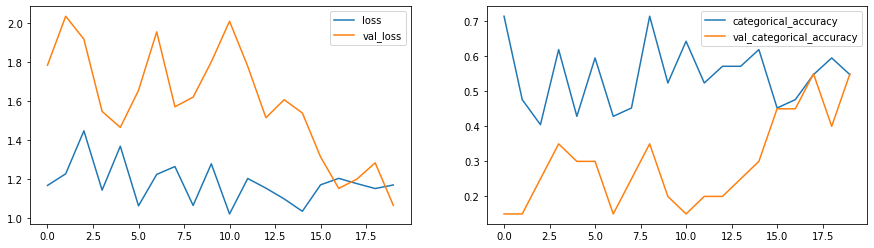

In [21]:
plot_score(history)

### Experiment 11 - with CNN + LSTM  -  epoch =20 , batch size = 50 , learning_rate=0.0002




In [22]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 25s 2s/step - loss: 1.3025 - categorical_accuracy: 0.4524 - val_loss: 1.6502 - val_categorical_accuracy: 0.1000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-1.30246-0.45238-1.65021-0.10000.h5
Epoch 2/20
14/14 [==============================] - 22s 2s/step - loss: 1.1682 - categorical_accuracy: 0.5000 - val_loss: 1.3198 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-1.16820-0.50000-1.31979-0.55000.h5
Epoch 3/20
14/14 [==============================] - 22s 2s/step - loss: 1.1394 - categorical_accuracy: 0.5000 - val_loss: 1.6281 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-1.13939-0.50000-1.62810-0.45000.h5
Epoch 4/20
14/14 [=============

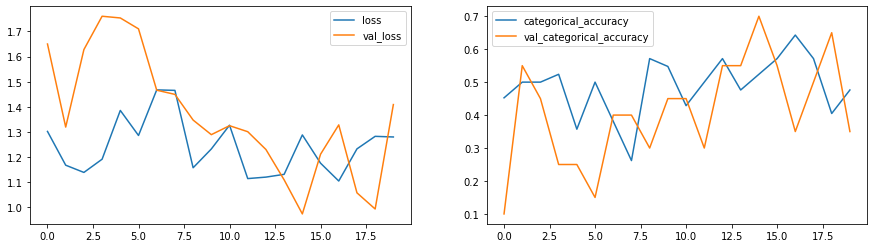

In [23]:
plot_score(history)

### Experiment 12 - with CNN + LSTM  -  epoch =20 , batch size = 25 , learning_rate=0.0002

In [24]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 44s 2s/step - loss: 1.2700 - categorical_accuracy: 0.4444 - val_loss: 1.8884 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00001-1.26999-0.44444-1.88839-0.35000.h5
Epoch 2/20
27/27 [==============================] - 38s 1s/step - loss: 1.1934 - categorical_accuracy: 0.5309 - val_loss: 2.1381 - val_categorical_accuracy: 0.2750

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00002-1.19337-0.53086-2.13814-0.27500.h5
Epoch 3/20
27/27 [==============================] - 40s 2s/step - loss: 1.1777 - categorical_accuracy: 0.5432 - val_loss: 2.2141 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2620_19_20.856568/model-00003-1.17773-0.54321-2.21409-0.20000.h5

Epoch 00003: ReduceLROnPlateau

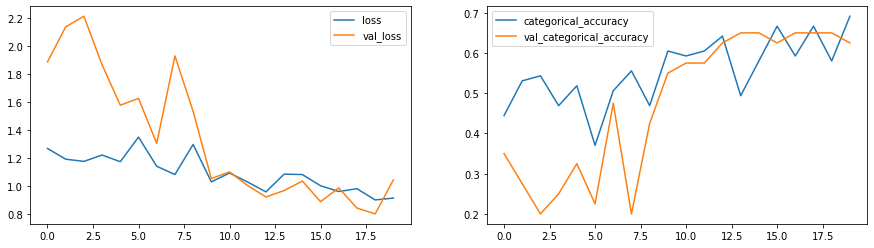

In [25]:
plot_score(history)